# Importing and installing libraries and getting model

In [ ]:
# install required libraries
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
# Import required libraries
from IPython.display import display, Javascript
from base64 import b64decode, b64encode
from google.colab.output import eval_js
from collections import defaultdict
import matplotlib.pyplot as plt
from roboflow import Roboflow
from tqdm import tqdm
import numpy as np
import time
import json
import cv2
import PIL
import os
import io

In [ ]:
# Get model and dataset from roboflow with API key
rf = Roboflow(api_key="QHR2uTKh7li9rZsWYR2Q")
project = rf.workspace("sikomps").project("cv-final-project-tapfy")
version = project.version(4)
dataset = version.download("yolov11")
model = project.version(4).model

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CV-Final-project-4 in yolov11:: 100%|██████████| 8517/8517 [00:02<00:00, 3864.07it/s]


# Evaluation

Processing test images: 100%|██████████| 176/176 [01:10<00:00,  2.51it/s]


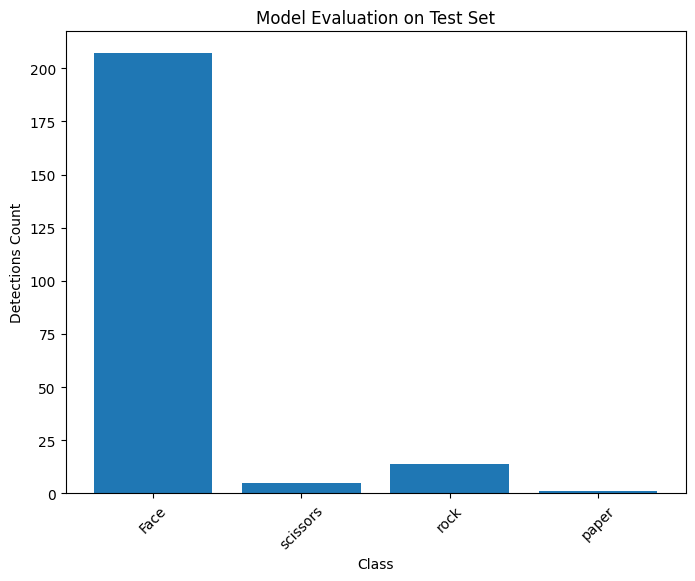

In [ ]:
def evaluate_test_set(model, test_images_path, confidence=40, overlap=50):
    results = []

    for img_file in tqdm(os.listdir(test_images_path), desc="Processing test images"):
        if img_file.lower().endswith((".jpg", ".png", ".jpeg")):  # Ensure valid image files
            img_path = os.path.join(test_images_path, img_file)
            prediction = model.predict(img_path, confidence=confidence, overlap=overlap).json()
            results.append(prediction)

    return results

def count_detections_per_class(results):
    class_counts = defaultdict(int)
    for result in results:
        for prediction in result.get("predictions", []):
            class_name = prediction.get("class")
            class_counts[class_name] += 1
    return class_counts

def plot_detections(class_counts):
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Class")
    plt.ylabel("Detections Count")
    plt.title("Model Evaluation on Test Set")
    plt.xticks(rotation=45)
    plt.show()

test_images_path = "/content/CV-Final-project-4/test/images"
test_results = evaluate_test_set(model, test_images_path)
class_counts = count_detections_per_class(test_results)
plot_detections(class_counts)

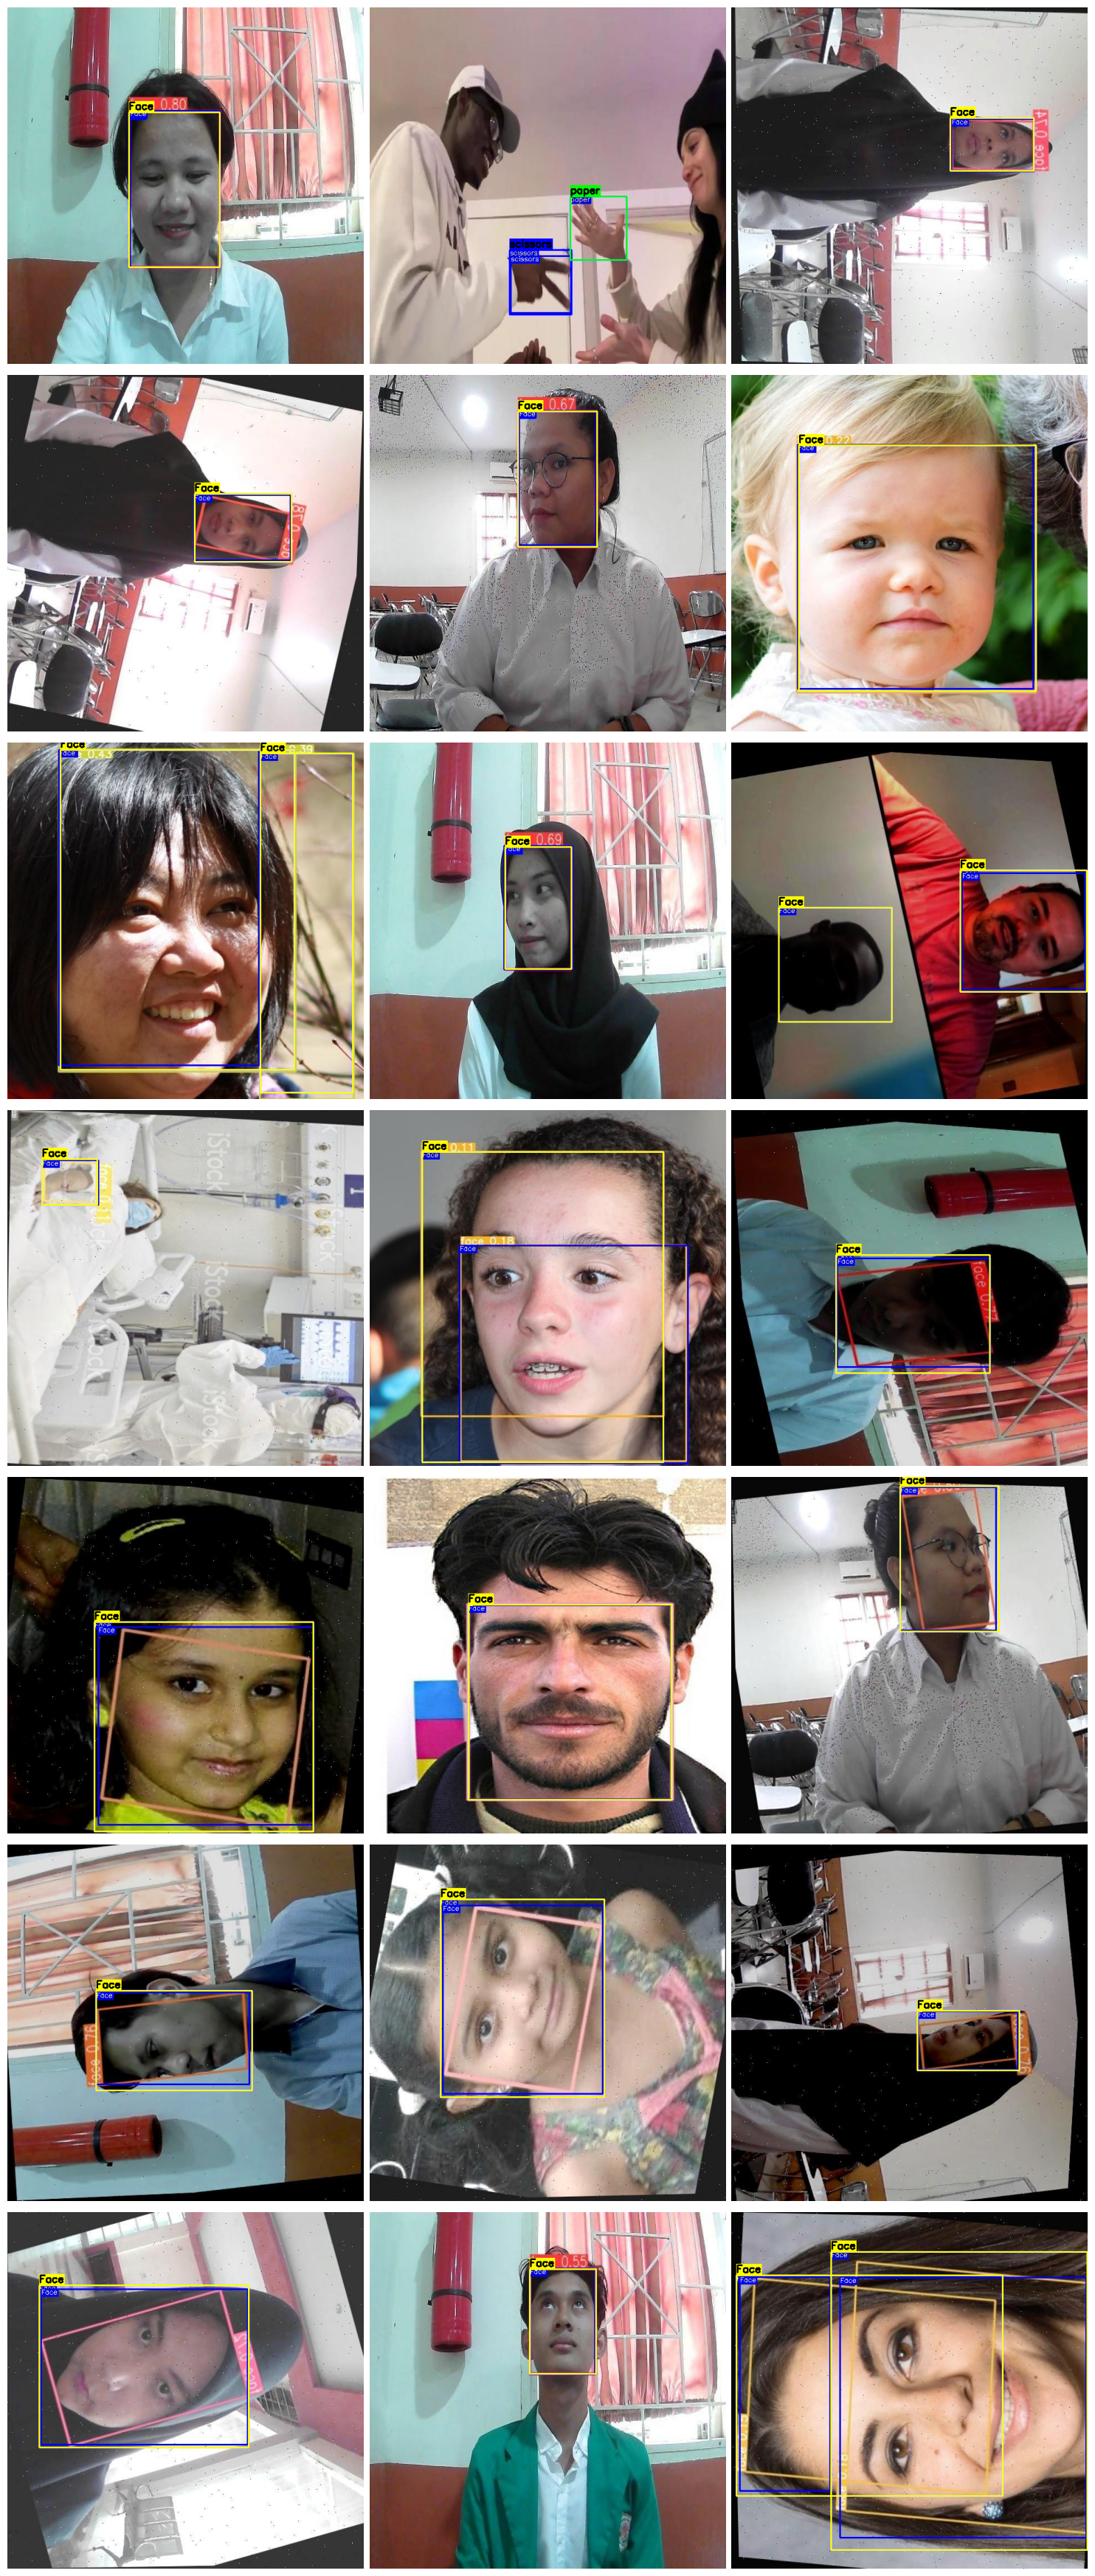

In [ ]:
COLORS = {
    "rock": (255, 0, 0),       # Red
    "paper": (0, 255, 0),      # Green
    "scissors": (0, 0, 255),   # Blue
    "face": (255, 255, 0)      # Yellow
}

def draw_bounding_boxes(image_path, predictions):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for prediction in predictions:
        x = int(prediction["x"] - prediction["width"] / 2)
        y = int(prediction["y"] - prediction["height"] / 2)
        w = int(prediction["width"])
        h = int(prediction["height"])
        class_name = prediction["class"]

        color = COLORS.get(class_name, COLORS["face"])

        # Draw bounding box
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)

        # Add semi-transparent label background
        (text_w, text_h), _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (x, y - 20), (x + text_w, y), color, -1)

        cv2.putText(img, class_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    return img

def display_images_in_grid(images, cols=3):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

test_images_path = "/content/CV-Final-project-4/test/images"
output_dir = "/content/test_predictions"
sample_images = [file for file in os.listdir(test_images_path) if file.endswith((".jpg", ".png", ".jpeg"))][:21]
display_images = []

for img_file in sample_images:
    img_path = os.path.join(test_images_path, img_file)
    json_path = os.path.join(output_dir, f"{img_file}.json")

    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            prediction_data = json.load(f)
            predictions = prediction_data.get("predictions", [])

            # Draw bounding boxes and collect images
            annotated_img = draw_bounding_boxes(img_path, predictions)
            display_images.append(annotated_img)

display_images_in_grid(display_images)

# Helper Functions for webcam

In [ ]:
def video_stream():
    js = Javascript('''
      var video;
      var div = null;
      var stream;
      var captureCanvas;
      var imgElement;
      var labelElement;

      var pendingResolve = null;
      var shutdown = false;

      function removeDom() {
         if (stream) {
           stream.getVideoTracks()[0].stop();
         }
         if (video) {
           video.remove();
         }
         if (div) {
           div.remove();
         }
         video = null;
         div = null;
         stream = null;
         imgElement = null;
         captureCanvas = null;
         labelElement = null;
      }

      function onAnimationFrame() {
        if (!shutdown) {
          window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
          var result = "";
          if (!shutdown) {
            captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 800);
            result = captureCanvas.toDataURL('image/jpeg', 0.8)
          }
          var lp = pendingResolve;
          pendingResolve = null;
          lp(result);
        }
      }

      async function createDom() {
        if (div !== null) {
          return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);

        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);

        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}}
        );
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);

        const instruction = document.createElement('div');
        instruction.innerHTML =
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };

        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 800;
        captureCanvas.height = 800;
        window.requestAnimationFrame(onAnimationFrame);

        return stream;
      }

      async function stream_frame(label, imgData) {
        if (shutdown) {
          removeDom();
          shutdown = false;
          return '';
        }

        var preCreate = Date.now();
        stream = await createDom();

        var preShow = Date.now();
        if (label != "") {
          labelElement.innerHTML = label;
        }

        if (imgData != "") {
          var videoRect = video.getClientRects()[0];
          imgElement.style.top = videoRect.top + "px";
          imgElement.style.left = videoRect.left + "px";
          imgElement.style.width = videoRect.width + "px";
          imgElement.style.height = videoRect.height + "px";
          imgElement.src = imgData;
        }

        var preCapture = Date.now();
        var result = await new Promise(function(resolve, reject) {
          pendingResolve = resolve;
        });
        shutdown = false;

        return {'create': preShow - preCreate,
                'show': preCapture - preShow,
                'capture': Date.now() - preCapture,
                'img': result};
      }
    ''')
    display(js)

def video_frame(label, bbox):
    return eval_js('stream_frame("{}", "{}")'.format(label, bbox))

def js_to_image(js_reply):
    if not js_reply:
        return None
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format(
        (str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Game

In [ ]:
# Load the crown image with transparency and convert to RGBA
crown_img = cv2.cvtColor(cv2.imread("/content/crown.png", cv2.IMREAD_UNCHANGED), cv2.COLOR_BGRA2RGBA)
crown_img = cv2.resize(crown_img, (200, 200))

In [ ]:
video_stream()
bbox = ''  # initially empty overlay
player1_score = 0
player2_score = 0
rules = {
    "rock": "scissor",
    "scissor": "paper",
    "paper": "rock"
}
game_started = False
locked_player1_gesture = None
locked_player2_gesture = None
final_player1_gesture = None
final_player2_gesture = None
font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    # Grab frame
    js_reply = video_frame('Capturing...', bbox)
    frame = js_to_image(js_reply["img"]) if js_reply else None
    if frame is None:
        continue

    overlay_height, overlay_width = frame.shape[:2]
    bbox_array = np.zeros([overlay_height, overlay_width, 4], dtype=np.uint8)

    # Dividing line
    screen_midpoint = overlay_width // 2
    cv2.line(
        bbox_array,
        (screen_midpoint, 0),
        (screen_midpoint, overlay_height),
        (0, 0, 255, 255),
        3
    )

    # Scores
    font_scale = 0.8
    thickness = 2
    top_y = 30

    text_player1 = f"Player 1: {player1_score}"
    text_player2 = f"Player 2: {player2_score}"

    # Player1
    text_size1 = cv2.getTextSize(text_player1, font, font_scale, thickness)[0]
    player1_x = (screen_midpoint // 2) - (text_size1[0] // 2)
    cv2.putText(
        bbox_array,
        text_player1,
        (player1_x, top_y),
        font,
        font_scale,
        (0, 255, 0, 255),
        thickness
    )

    # Player2
    text_size2 = cv2.getTextSize(text_player2, font, font_scale, thickness)[0]
    player2_x = screen_midpoint + (screen_midpoint // 2) - (text_size2[0] // 2)
    cv2.putText(
        bbox_array,
        text_player2,
        (player2_x, top_y),
        font,
        font_scale,
        (0, 255, 0, 255),
        thickness
    )

    # "Best of 3" in the middle top
    text_win_score = "3"
    text_size_win = cv2.getTextSize(text_win_score, font, 0.9, 3)[0]
    text_x_win = screen_midpoint - text_size_win[0] // 2
    cv2.putText(
        bbox_array,
        text_win_score,
        (text_x_win, top_y),
        font,
        0.9,
        (255, 0, 0, 255),
        3
    )

    # real-time RPS for overlay
    predictions = model.predict(frame, confidence=40, overlap=50).json()
    current_player1_gesture = None
    current_player2_gesture = None

    for pred in predictions['predictions']:
        label = pred['class']
        conf = pred['confidence']
        x = pred['x']
        y = pred['y']
        w = pred['width']
        h = pred['height']

        # Calculate bounding box
        left = int(x - w / 2)
        top = int(y - h / 2)
        right = int(x + w / 2)
        bottom = int(y + h / 2)

        # Ensure coordinates stay within the frame's dimensions
        left = max(0, min(left, overlay_width - 1))
        top = max(0, min(top, overlay_height - 1))
        right = max(0, min(right, overlay_width - 1))
        bottom = max(0, min(bottom, overlay_height - 1))

        if x < screen_midpoint and label != 'Face':
            current_player1_gesture = label
        elif label != 'Face':
            current_player2_gesture = label

        # Draw rectangle and label
        color = (0, 255, 0, 255)
        cv2.rectangle(bbox_array, (left, top), (right, bottom), color, 2)
        cv2.putText(
            bbox_array,
            f"{label} [{conf:.2f}]",
            (left, top - 5),
            font,
            0.5,
            color,
            2
        )

    # Game Logic
    if not game_started:
    # Wait for both players to show rock
        if current_player1_gesture == "rock" and current_player2_gesture == "rock":
            # Track bounding box changes
            p1_countdown_bboxes = []
            p2_countdown_bboxes = []

            # Countdown
            for i in range(3, 0, -1):
                # 1) Grab new frame for each second of the countdown
                frame_reply = video_frame("Starting Countdown...", "")
                countdown_frame = js_to_image(frame_reply["img"])
                if countdown_frame is None:
                    continue

                # Create fresh overlay
                h_, w_ = countdown_frame.shape[:2]
                countdown_overlay = np.zeros([h_, w_, 4], dtype=np.uint8)

                # Re-run predictions on the new frame
                preds_countdown = model.predict(countdown_frame, confidence=40, overlap=50).json()
                for det in preds_countdown["predictions"]:
                    cls = det["class"]
                    conf = det["confidence"]
                    xx = det["x"]
                    yy = det["y"]
                    ww = det["width"]
                    hh = det["height"]

                    left = int(xx - ww/2)
                    top = int(yy - hh/2)
                    right = int(xx + ww/2)
                    bottom = int(yy + hh/2)

                    color = (0, 255, 0, 255)
                    cv2.rectangle(countdown_overlay, (left, top), (right, bottom), color, 2)
                    cv2.putText(
                        countdown_overlay,
                        f"{cls} [{conf:.2f}]",
                        (left, top - 5),
                        font,
                        0.5,
                        color,
                        2
                    )

                    # Store bounding boxes
                    if xx < screen_midpoint:
                        p1_countdown_bboxes.append((left, top, right, bottom))
                    else:
                        p2_countdown_bboxes.append((left, top, right, bottom))

                # Add the countdown number
                countdown_text = str(i)
                text_size_countdown = cv2.getTextSize(countdown_text, font, 1.5, 3)[0]
                text_x_countdown = (w_ // 2) - (text_size_countdown[0] // 2)
                text_y_countdown = h_ // 2

                cv2.putText(
                    countdown_overlay,
                    countdown_text,
                    (text_x_countdown, text_y_countdown),
                    font,
                    1.5,
                    (0, 255, 0, 255),
                    3
                )

                # Convert overlay to RGBA, send to webcam overlay
                countdown_overlay[:, :, 3] = (countdown_overlay.max(axis=2) > 0).astype(int) * 255
                bbox_bytes = bbox_to_bytes(countdown_overlay)
                video_frame("", bbox_bytes)

            # Check bounding-box changes to detect cheaters
            def all_same(lst, threshold=20):
                if len(lst) < 2:
                    return False

                def within_threshold(box1, box2, thr):
                    (l1, t1, r1, b1) = box1
                    (l2, t2, r2, b2) = box2
                    return (abs(l1 - l2) <= thr and abs(t1 - t2) <= thr and
                            abs(r1 - r2) <= thr and abs(b1 - b2) <= thr)

                first_box = lst[0]
                for box in lst[1:]:
                    if not within_threshold(first_box, box, threshold):
                        return False
                return True

            cheaters = []
            if all_same(p1_countdown_bboxes):
                player1_score -= 1
                cheaters.append("Player 1")
            if all_same(p2_countdown_bboxes):
                player2_score -= 1
                cheaters.append("Player 2")

            if cheaters:
                if len(cheaters) == 2:
                    result_text = "Both Players CHEATED 1!"
                else:
                    result_text = f"{cheaters[0]} is a CHEATER 1!"

                cheat_overlay = countdown_overlay.copy()
                txt_sz = cv2.getTextSize(result_text, font, 0.8, 2)[0]
                rx = screen_midpoint - (txt_sz[0] // 2)
                ry = overlay_height // 2
                cv2.putText(
                    cheat_overlay,
                    result_text,
                    (rx, ry),
                    font,
                    0.8,
                    (255, 255, 255, 255),
                    2
                )
                cheat_overlay[:, :, 3] = (cheat_overlay.max(axis=2) > 0).astype(int) * 255
                cheat_bytes = bbox_to_bytes(cheat_overlay)
                video_frame("", cheat_bytes)
                time.sleep(2)
                game_started = False
                continue

            # FIRST 3-SECOND window
            lock_start = time.time()
            locked_player1_gesture = None
            locked_player2_gesture = None

            while (time.time() - lock_start) < 3:
                # Get new frame
                frame_reply = video_frame("Locking Gestures", "")
                new_frame = js_to_image(frame_reply["img"])
                if new_frame is None:
                    continue

                # Create new overlay for bounding boxes
                h_, w_ = new_frame.shape[:2]
                lock_overlay = np.zeros([h_, w_, 4], dtype=np.uint8)

                # Run predictions on new_frame
                preds_lock = model.predict(new_frame, confidence=40, overlap=50).json()
                p1_gest = None
                p2_gest = None
                midpoint_ = w_ // 2

                for det in preds_lock["predictions"]:
                    cls = det["class"]
                    xx = det["x"]
                    yy = det["y"]
                    ww = det["width"]
                    hh = det["height"]

                    left   = int(xx - ww/2)
                    top    = int(yy - hh/2)
                    right  = int(xx + ww/2)
                    bottom = int(yy + hh/2)

                    color = (0, 255, 0, 255)
                    cv2.rectangle(lock_overlay, (left, top), (right, bottom), color, 2)
                    cv2.putText(
                        lock_overlay,
                        cls,
                        (left, top - 5),
                        font,
                        0.7,
                        color,
                        2
                    )

                    # decide P1 or P2
                    if xx < midpoint_ and cls != 'Face':
                        p1_gest = cls
                    elif cls != 'Face':
                        p2_gest = cls

                # Keep track of last recognized
                if p1_gest:
                    locked_player1_gesture = p1_gest
                if p2_gest:
                    locked_player2_gesture = p2_gest

                # Draw a text message on the overlay
                lock_text = "Lock your first move!"
                t_size = cv2.getTextSize(lock_text, font, 0.9, 2)[0]
                tx = midpoint_ - (t_size[0] // 2)
                ty = h_ // 2
                cv2.putText(
                    lock_overlay,
                    lock_text,
                    (tx, ty),
                    font,
                    0.9,
                    (255, 255, 0, 255),
                    2
                )

                # Dividing line so we see left vs right
                cv2.line(lock_overlay, (midpoint_,0), (midpoint_,h_), (0,0,255,255), 3)

                # Send overlay to video_frame
                lock_overlay[:, :, 3] = (lock_overlay.max(axis=2) > 0).astype(int)*255
                overlay_bytes = bbox_to_bytes(lock_overlay)
                _ = video_frame("", overlay_bytes)

            # SECOND 3-SECOND window
            final_start = time.time()
            final_player1_gesture = None
            final_player2_gesture = None

            while (time.time() - final_start) < 3:
                frame_reply = video_frame("Final Gestures", "")
                new_frame = js_to_image(frame_reply["img"])
                if new_frame is None:
                    continue

                # New overlay
                h_, w_ = new_frame.shape[:2]
                final_overlay = np.zeros([h_, w_, 4], dtype=np.uint8)

                preds_final = model.predict(new_frame, confidence=30, overlap=30).json()
                p1_gest_f = None
                p2_gest_f = None
                midpoint_ = w_ // 2

                for det in preds_final["predictions"]:
                    cls = det["class"]
                    xx = det["x"]
                    yy = det["y"]
                    ww = det["width"]
                    hh = det["height"]

                    left   = int(xx - ww/2)
                    top    = int(yy - hh/2)
                    right  = int(xx + ww/2)
                    bottom = int(yy + hh/2)

                    color = (0, 255, 0, 255)
                    cv2.rectangle(final_overlay, (left, top), (right, bottom), color, 2)
                    cv2.putText(
                        final_overlay,
                        cls,
                        (left, top - 5),
                        font,
                        0.7,
                        color,
                        2
                    )

                    if xx < midpoint_ and cls != 'Face':
                        p1_gest_f = cls
                    elif cls != 'Face':
                        p2_gest_f = cls

                if p1_gest_f:
                    final_player1_gesture = p1_gest_f
                if p2_gest_f:
                    final_player2_gesture = p2_gest_f

                final_text = "Final move?"
                t_size = cv2.getTextSize(final_text, font, 0.9, 2)[0]
                tx = midpoint_ - (t_size[0] // 2)
                ty = h_ // 2
                cv2.putText(
                    final_overlay,
                    final_text,
                    (tx, ty),
                    font,
                    0.9,
                    (255, 255, 255, 255),
                    2
                )

                cv2.line(final_overlay, (midpoint_,0), (midpoint_,h_), (0,0,255,255), 3)

                final_overlay[:, :, 3] = (final_overlay.max(axis=2) > 0).astype(int)*255
                overlay_bytes = bbox_to_bytes(final_overlay)
                video_frame("", overlay_bytes)

            # Done with both windows
            game_started = True
        else:
            prompt_text = "Both must show ROCK to start"
            text_size_prompt = cv2.getTextSize(prompt_text, font, 0.6, 2)[0]
            text_x_prompt = screen_midpoint - text_size_prompt[0] // 2
            text_y_prompt = overlay_height // 2

            cv2.putText(
                bbox_array,
                prompt_text,
                (text_x_prompt, text_y_prompt),
                font,
                0.6,
                (255, 255, 255, 255),
                2
            )
    else:
        # Scoring and Cheating
        result_text = ""
        p1_cheater = False
        p2_cheater = False

        if locked_player1_gesture != final_player1_gesture:
            p1_cheater = True
            result_text = "Player 1 is a CHEATER 2!"
            player1_score -= 1
        if locked_player2_gesture != final_player2_gesture:
            p2_cheater = True
            player2_score -= 1
            if p1_cheater:
                result_text = "Both Players CHEATED 2!"
            else:
                p = "Player 2 is a CHEATER 2!"

        # Determine the winner if no cheating occurred
        if not (p1_cheater or p2_cheater):
            if final_player1_gesture == final_player2_gesture:
                result_text = "Draw!"
            else:
                if rules[final_player1_gesture] == final_player2_gesture:
                    result_text = "Player 1 Wins!"
                    player1_score += 1
                else:
                    result_text = "Player 2 Wins!"
                    player2_score += 1
        winner_box = None
        if p1_cheater or p2_cheater:
            # Overlay a red mask on the cheater's Face gestures
            for pred in predictions['predictions']:
                if pred['class'] == 'Face':  # Check if it's a face
                    # Extract bounding box for the face
                    left = int(pred['x'] - pred['width'] / 2)
                    top = int(pred['y'] - pred['height'] / 2)
                    right = int(pred['x'] + pred['width'] / 2)
                    bottom = int(pred['y'] + pred['height'] / 2)

                    # Clip the coordinates to ensure they are within the frame
                    left = max(0, min(left, overlay_width - 1))
                    top = max(0, min(top, overlay_height - 1))
                    right = max(0, min(right, overlay_width - 1))
                    bottom = max(0, min(bottom, overlay_height - 1))

                    # Adjust to focus only on the bottom half of the face
                    half_height = (bottom - top) // 2  # Half of the face's height
                    top = bottom - half_height  # Adjust the top to the lower half

                    # Only draw the red mask for the cheater
                    if p1_cheater and left < screen_midpoint:  # If Player 1 is a cheater and the face is on their side
                        # Red mask for Player 1's face
                        red_mask = bbox_array.copy()
                        cv2.rectangle(
                            red_mask,
                            (left, top),
                            (right, bottom),
                            (255, 0, 0, 150),  # Red color with transparency
                            thickness=-1  # Filled rectangle
                        )
                        # Blend the red mask with the original frame
                        alpha = 0.5  # Transparency factor
                        cv2.addWeighted(red_mask, alpha, bbox_array, 1 - alpha, 0, bbox_array)
                        # Draw bounding box for the face (optional)
                        cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)

                    elif p2_cheater and left >= screen_midpoint:  # If Player 2 is a cheater and the face is on their side
                        # Red mask for Player 2's face
                        red_mask = bbox_array.copy()
                        cv2.rectangle(
                            red_mask,
                            (left, top),
                            (right, bottom),
                            (255, 0, 0, 150),  # Red color with transparency
                            thickness=-1  # Filled rectangle
                        )
                        # Blend the red mask with the original frame
                        alpha = 0.5  # Transparency factor
                        cv2.addWeighted(red_mask, alpha, bbox_array, 1 - alpha, 0, bbox_array)
                        # Draw bounding box for the face (optional)
                        cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)

            bbox_bytes = bbox_to_bytes(bbox_array)  # Convert overlay to bytes
            video_frame("", bbox_bytes)  # Send overlay to webcam
            time.sleep(2)  # Pause for 2 seconds to display cheat detection
            p1_cheater = False  # Reset cheat flags after display
            p2_cheater = False

        # Find the winner's bounding box and overlay the crown on the winner's face
        if not (p1_cheater or p2_cheater):
            if result_text == "Player 1 Wins!" and current_player1_gesture:
                # Find Player 1's face
                for pred in predictions['predictions']:
                    if pred['class'] == 'Face' and pred['x'] < screen_midpoint:
                        # Find Player 1's face bounding box
                        left = int(pred['x'] - pred['width'] / 2)
                        top = int(pred['y'] - pred['height'] / 2)
                        width = int(pred['width'])
                        height = int(pred['height'])

                        # Position crown above face
                        h_crown, w_crown = crown_img.shape[:2]
                        crown_x = left + (width - w_crown) // 2  # Center horizontally
                        crown_y = max(top - h_crown + 40, 0)     # Place above the face

                        # Boundary checks
                        crown_x = max(0, min(crown_x, bbox_array.shape[1] - w_crown))
                        crown_y = max(0, crown_y)

                        # Overlay crown with transparency
                        alpha_crown = crown_img[:, :, 3] / 255.0
                        for c in range(3):  # For B, G, R channels
                            bbox_array[crown_y:crown_y+h_crown, crown_x:crown_x+w_crown, c] = (
                                alpha_crown * crown_img[:, :, c] +
                                (1 - alpha_crown) * bbox_array[crown_y:crown_y+h_crown, crown_x:crown_x+w_crown, c]
                            )

                        time.sleep(2)
                        break  # Exit the loop after placing the crown

            elif result_text == "Player 2 Wins!" and current_player2_gesture:
                # Find Player 2's face
                for pred in predictions['predictions']:
                    if pred['class'] == 'Face' and pred['x'] >= screen_midpoint:
                        # Find Player 2's face bounding box
                        left = int(pred['x'] - pred['width'] / 2)
                        top = int(pred['y'] - pred['height'] / 2)
                        width = int(pred['width'])
                        height = int(pred['height'])

                        # Position crown slightly above the face bounding box
                        crown_x = left + width // 4
                        crown_y = max(top - 60, 0)  # Move crown up, ensuring it doesn't go off-screen

                        # Get the crown region within bbox_array
                        h_crown, w_crown = crown_img.shape[:2]

                        # Ensure the crown doesn't go out of frame
                        if crown_y + h_crown >= bbox_array.shape[0] or crown_x + w_crown >= bbox_array.shape[1]:
                            h_crown = min(h_crown, bbox_array.shape[0] - crown_y)
                            w_crown = min(w_crown, bbox_array.shape[1] - crown_x)
                            crown_img = crown_img[:h_crown, :w_crown]  # Crop crown if needed

                        # Overlay the crown with transparency
                        for c in range(3):  # For each color channel (B, G, R)
                            bbox_array[crown_y:crown_y+h_crown, crown_x:crown_x+w_crown, c] = (
                                crown_img[:h_crown, :w_crown, c] * (crown_img[:h_crown, :w_crown, 3] / 255.0) +
                                bbox_array[crown_y:crown_y+h_crown, crown_x:crown_x+w_crown, c] * (1.0 - crown_img[:h_crown, :w_crown, 3] / 255.0)
                            )
                        time.sleep(2)
                        break  # Exit the loop after placing the crown

        text_size_result = cv2.getTextSize(result_text, font, 0.8, 2)[0]
        result_x = screen_midpoint - (text_size_result[0] // 2)
        result_y = overlay_height // 2
        cv2.putText(
            bbox_array,
            result_text,
            (result_x, result_y),
            font,
            0.8,
            (255, 255, 255, 255),
            2
        )

        # Reset for next round
        game_started = False
        time.sleep(2)
    # Final overlay for the main loop
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox = bbox_to_bytes(bbox_array)
    if player1_score == 3 or player2_score == 3:
        print(f'Player {1 if player1_score == 3 else 2} Won')
        break

<IPython.core.display.Javascript object>